In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE   # optional, install imbalanced-learn


In [2]:
CSV_PATH = r"D:\data_engineering\fraud_detection\data\raw\creditcard.csv"
MODEL_SAVE_PATH = r"D:\data_engineering\fraud_detection\2_stream_processing\model_training\lightgbm_model.pkl"
RANDOM_STATE = 42


In [3]:
df=pd.read_csv(CSV_PATH)
print("load rows:",len(df))
df.head()

load rows: 284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
print(df['Class'].value_counts())
print(df.describe().T[['mean', 'std', 'min', 'max']])

# Fraction of fraud
fraud_frac = df['Class'].mean()
print(f"Fraud fraction: {fraud_frac:.6f}")


Class
0    284315
1       492
Name: count, dtype: int64
                mean           std         min            max
Time    9.481386e+04  47488.145955    0.000000  172792.000000
V1      1.168375e-15      1.958696  -56.407510       2.454930
V2      3.416908e-16      1.651309  -72.715728      22.057729
V3     -1.379537e-15      1.516255  -48.325589       9.382558
V4      2.074095e-15      1.415869   -5.683171      16.875344
V5      9.604066e-16      1.380247 -113.743307      34.801666
V6      1.487313e-15      1.332271  -26.160506      73.301626
V7     -5.556467e-16      1.237094  -43.557242     120.589494
V8      1.213481e-16      1.194353  -73.216718      20.007208
V9     -2.406331e-15      1.098632  -13.434066      15.594995
V10     2.239053e-15      1.088850  -24.588262      23.745136
V11     1.673327e-15      1.020713   -4.797473      12.018913
V12    -1.247012e-15      0.999201  -18.683715       7.848392
V13     8.190001e-16      0.995274   -5.791881       7.126883
V14     1.2072

In [7]:
V_COLS = [f"V{i}" for i in range(1,29)]
# create simple derived features
df["log_amount"] = np.log1p(df["Amount"])
df["v_mean"] = df[V_COLS].mean(axis=1)
df["v_std"] = df[V_COLS].std(axis=1)

FEATURES = V_COLS + ["Amount", "log_amount", "v_mean", "v_std"]
X = df[FEATURES].copy()
y = df["Class"].copy()
X.shape, y.shape


((284807, 32), (284807,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (227845, 32) Test: (56962, 32)


In [9]:
USE_SMOTE = False   # set True to try SMOTE (may increase recall but risk overfitting)
if USE_SMOTE:
    sm = SMOTE(random_state=RANDOM_STATE, n_jobs=-1)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("After SMOTE:", X_train_res.shape, y_train_res.sum(), "/", len(y_train_res))
else:
    X_train_res, y_train_res = X_train, y_train


In [ ]:
model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    class_weight="balanced",   # handles imbalance without SMOTE
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model.fit(X_train_res, y_train_res)
print("Training complete.")





























































[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training complete.


In [11]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

roc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", roc)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Precision-Recall AUC
prec, rec, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(rec, prec)
print("PR AUC:", pr_auc)


Classification report:
              precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998     56864
           1     0.8750    0.8571    0.8660        98

    accuracy                         0.9995     56962
   macro avg     0.9374    0.9285    0.9329     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC AUC: 0.974849766862288
Confusion matrix:
 [[56852    12]
 [   14    84]]
PR AUC: 0.8874267860808658


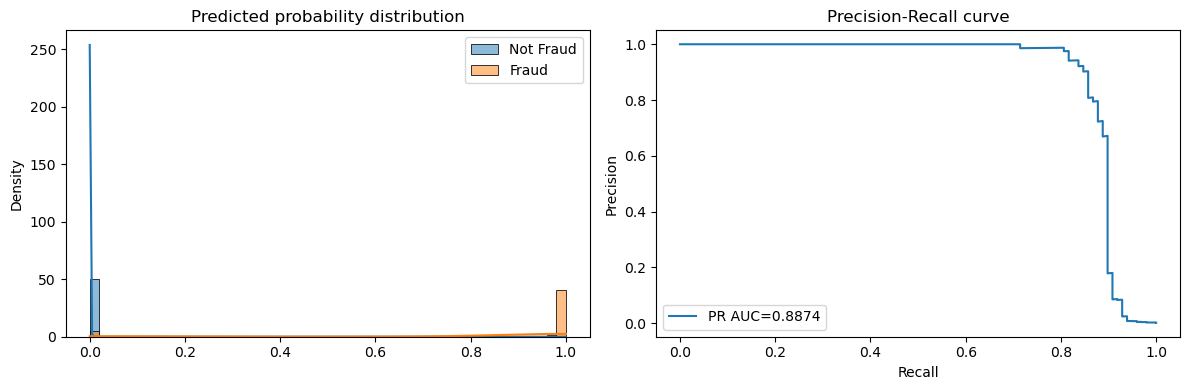

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(y_proba[y_test==0], label="Not Fraud", stat="density", kde=True, bins=50)
sns.histplot(y_proba[y_test==1], label="Fraud", stat="density", kde=True, bins=50)
plt.legend(); plt.title("Predicted probability distribution")

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"PR AUC={pr_auc:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall curve")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
artifact = {
    "model": model,
    "features": FEATURES,
    "version": "lightgbm_v1",
    "metrics": {
        "roc_auc": float(roc),
        "pr_auc": float(pr_auc)
    }
}

os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
with open(MODEL_SAVE_PATH, "wb") as f:
    pickle.dump(artifact, f)

print("Saved model to:", MODEL_SAVE_PATH)


Saved model to: D:\data_engineering\fraud_detection\2_stream_processing\model_training\lightgbm_model.pkl


In [14]:
with open(MODEL_SAVE_PATH, "rb") as f:
    art = pickle.load(f)
print("Loaded version:", art.get("version"))
print("Feature count:", len(art.get("features")))


Loaded version: lightgbm_v1
Feature count: 32
